# ⚡ Machine Learning Project: Electricity Price Explanation ⚙️📉

**LANOTTE-MORO Alix, CHANDECLERC Antoine, GILLES Julien, FLEURY Nathan**  
**November 14, 2024**

## Project Overview

This project focuses on analyzing daily variations in electricity futures prices within the European market, specifically for France and Germany. Given the complex interplay of meteorological, energy production, and geopolitical factors impacting price fluctuations, the objective is to build a model that explains these movements rather than predicting exact prices. Leveraging Spearman correlation as the primary evaluation metric, we will employ a range of models—from linear regression benchmarks to advanced machine learning approaches (e.g., Random Forests, XGBoost, and RNNs)—to capture both linear and non-linear influences on price variations. This model aims to support energy producers, traders, and policymakers by providing insights to optimize trading strategies, manage risks, and strengthen the resilience of the European energy grid.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler

from scipy.stats import spearmanr

import warnings 
warnings.filterwarnings("ignore")

## Data Importation and first preview

In [4]:
X_df =pd.read_csv('X_train_NHkHMNU.csv', delimiter= ',')
y_df =pd.read_csv('y_train_ZAN5mwg.csv', delimiter= ',')
X_test_df =pd.read_csv('X_test_final.csv', delimiter= ',')

df = pd.merge(X_df,y_df,on='ID')

print(df.shape)
df.head(10)

(1494, 36)


,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,TARGET
0,1054,206,FR,0.210099,-0.427458,-0.606523,0.606523,NaN,0.692860,NaN,...,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445,0.028313
1,2049,501,FR,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,...,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365,-0.112516
2,1924,687,FR,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,...,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952,-0.180840
3,297,720,DE,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,...,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948,-0.260356
4,1101,818,FR,0.143807,-0.617038,-0.924990,0.924990,NaN,0.990324,NaN,...,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378,-0.071733
5,1520,467,FR,-0.295296,-0.765120,-0.717490,0.717490,-1.117139,-0.200305,1.117139,...,-0.962519,-0.193837,-0.871600,-0.917234,0.102046,0.472708,0.891049,0.861408,1.124457,0.932105
6,1546,144,FR,-0.234965,-0.677085,0.399588,-0.399588,0.183998,-0.986235,-0.183998,...,-1.658394,-0.529800,-0.318920,-1.220760,-0.512991,0.147507,1.889739,0.498226,0.681739,0.192680
7,1069,1136,FR,0.332223,-0.546797,-0.507773,0.507773,NaN,0.569585,NaN,...,-0.744328,-0.051535,-0.701035,-0.394857,1.990978,0.902719,0.206769,0.993304,-0.223739,0.112850
8,1323,83,FR,-0.023023,-0.604694,-1.196787,1.196787,-0.519339,0.373109,0.519339,...,-0.207390,0.009356,-0.261496,-0.841560,-1.024980,-1.564174,2.688208,3.061210,3.755240,0.076153
9,1618,307,FR,0.564657,0.273776,-0.439063,0.439063,-0.636654,0.342057,0.636654,...,-0.972344,-0.806435,-0.752273,-0.767578,-0.371475,-0.459768,-1.487154,-0.692378,-0.768283,0.000000


### Pourcentage of missing values by columns

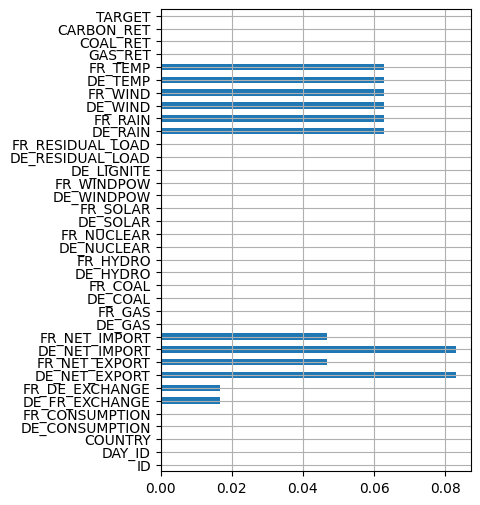

In [364]:
nb_missing = df.isna().sum()
rate_missing = nb_missing / df.ID.nunique()
fig, ax = plt.subplots(figsize=(4,6))
ax1 = ax
rate_missing.plot(kind="barh", ax=ax1)
ax1.grid()

We notice that there are a certain number of missing values, particularly for DE_NET_IMPORT and DE_NET_EXPORT, where the rate exceeds 8%. These data will need to be handled. Several options are available to us: filling them with the mean, replacing them with zeros, etc.

We chose to fill the missing values in each column with the respective column mean. Since the dataset is relatively small (around 1500 rows), dropping rows with missing values would significantly reduce the available data. By imputing missing values with the mean, we retain as many rows as possible, ensuring that the dataset remains comprehensive.

In [ ]:
#List of Columns with missing values
columns_to_fill = [
    "DE_FR_EXCHANGE", "FR_DE_EXCHANGE", "DE_NET_EXPORT", "FR_NET_EXPORT", 
    "DE_NET_IMPORT", "FR_NET_IMPORT", "DE_RAIN", "FR_RAIN", 
    "DE_WIND", "FR_WIND", "DE_TEMP", "FR_TEMP"
]
df_general = df

#Fill missing values with the mean
for column in columns_to_fill:
    if column in df_general.columns:
        df_general[column].fillna(df_general[column].mean(), inplace=True)

### Plot of the distribution of each columns of the data

Text(0.5, 1.0, 'TARGET')

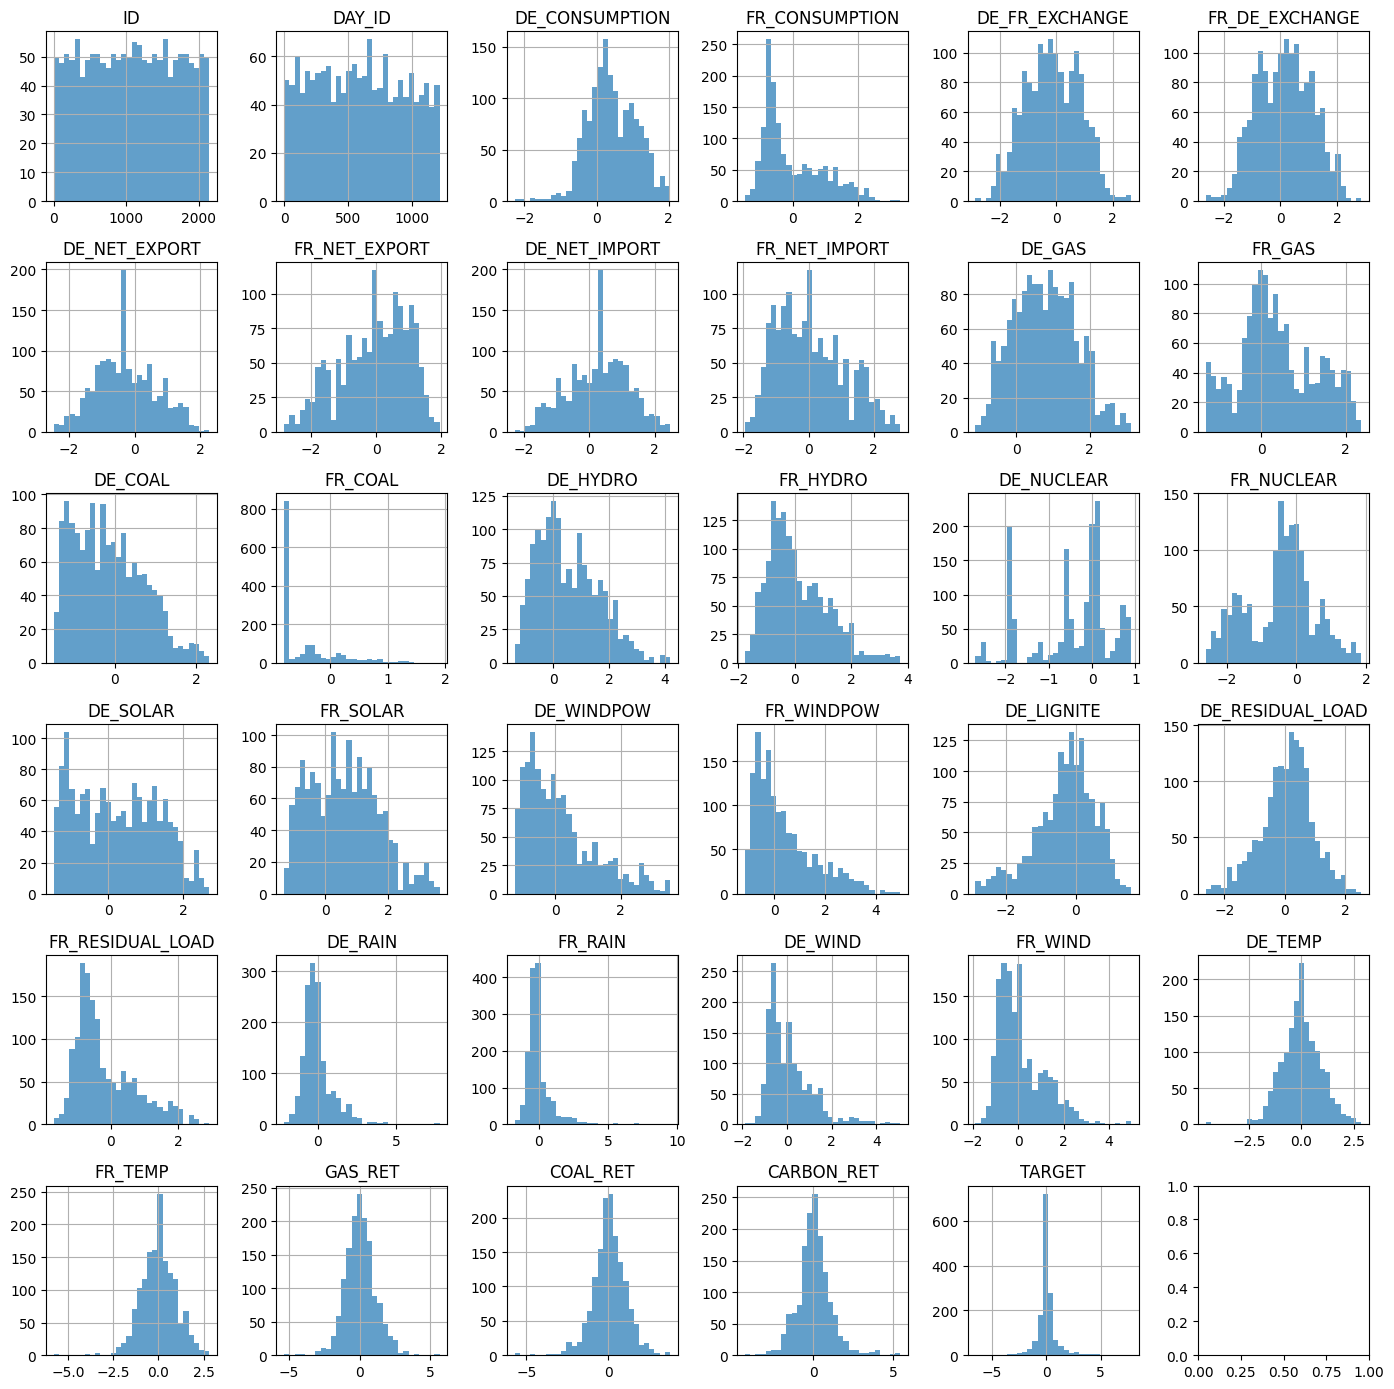

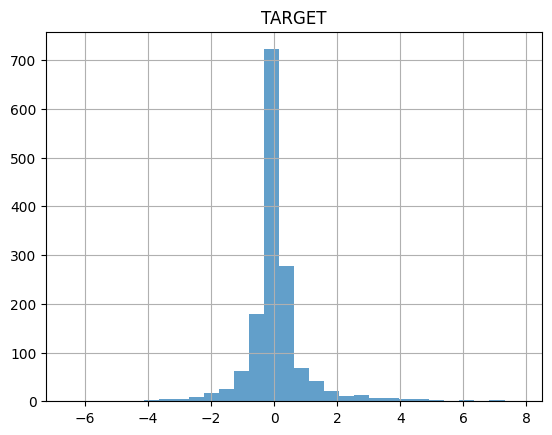

In [ ]:
features = [feature for feature in df.columns if feature != "COUNTRY"]

nb_col = 6
nb_row = - (-len(features)//6)
fig, ax = plt.subplots(nb_row, nb_col, figsize=(14,14))

for i, feature in enumerate(features):
    i_col = i % nb_col
    i_row = i // nb_col
    ax1 = ax[i_row, i_col]
    
    ax1.set_title(feature)
    ax1.grid()
    df[feature].hist(bins= 30, ax=ax1, alpha=0.7)

plt.tight_layout()

fig, ax = plt.subplots()
ax1 = ax
y_df["TARGET"].hist(bins= 30, ax=ax1, alpha=0.7)
ax1.set_title("TARGET")

In [370]:
#Distribution data points by country
print("Nb of data points by country:")
print(df.COUNTRY.value_counts())

Nb of data points by country:
COUNTRY
FR    851
DE    643
Name: count, dtype: int64


We aim to predict prices for France and Germany. To better understand the factors influencing price in each country, we will plot the data separately. This allows us to evaluate whether the factors driving price variations are consistent or differ between the two countries.

In [ ]:
#Divide the data by country, drop the country column and fill missing values with the mean
df_de = df[df['COUNTRY'] == 'DE']
df_de = df_de.drop(columns=['COUNTRY'])
df_de.fillna(df_de.mean(), inplace=True)

df_fr = df[df.COUNTRY == "FR"]
df_fr = df_fr.drop(columns=['COUNTRY'])
df_fr.fillna(df_fr.mean(), inplace=True)

### Plot of the distribution of each column by country

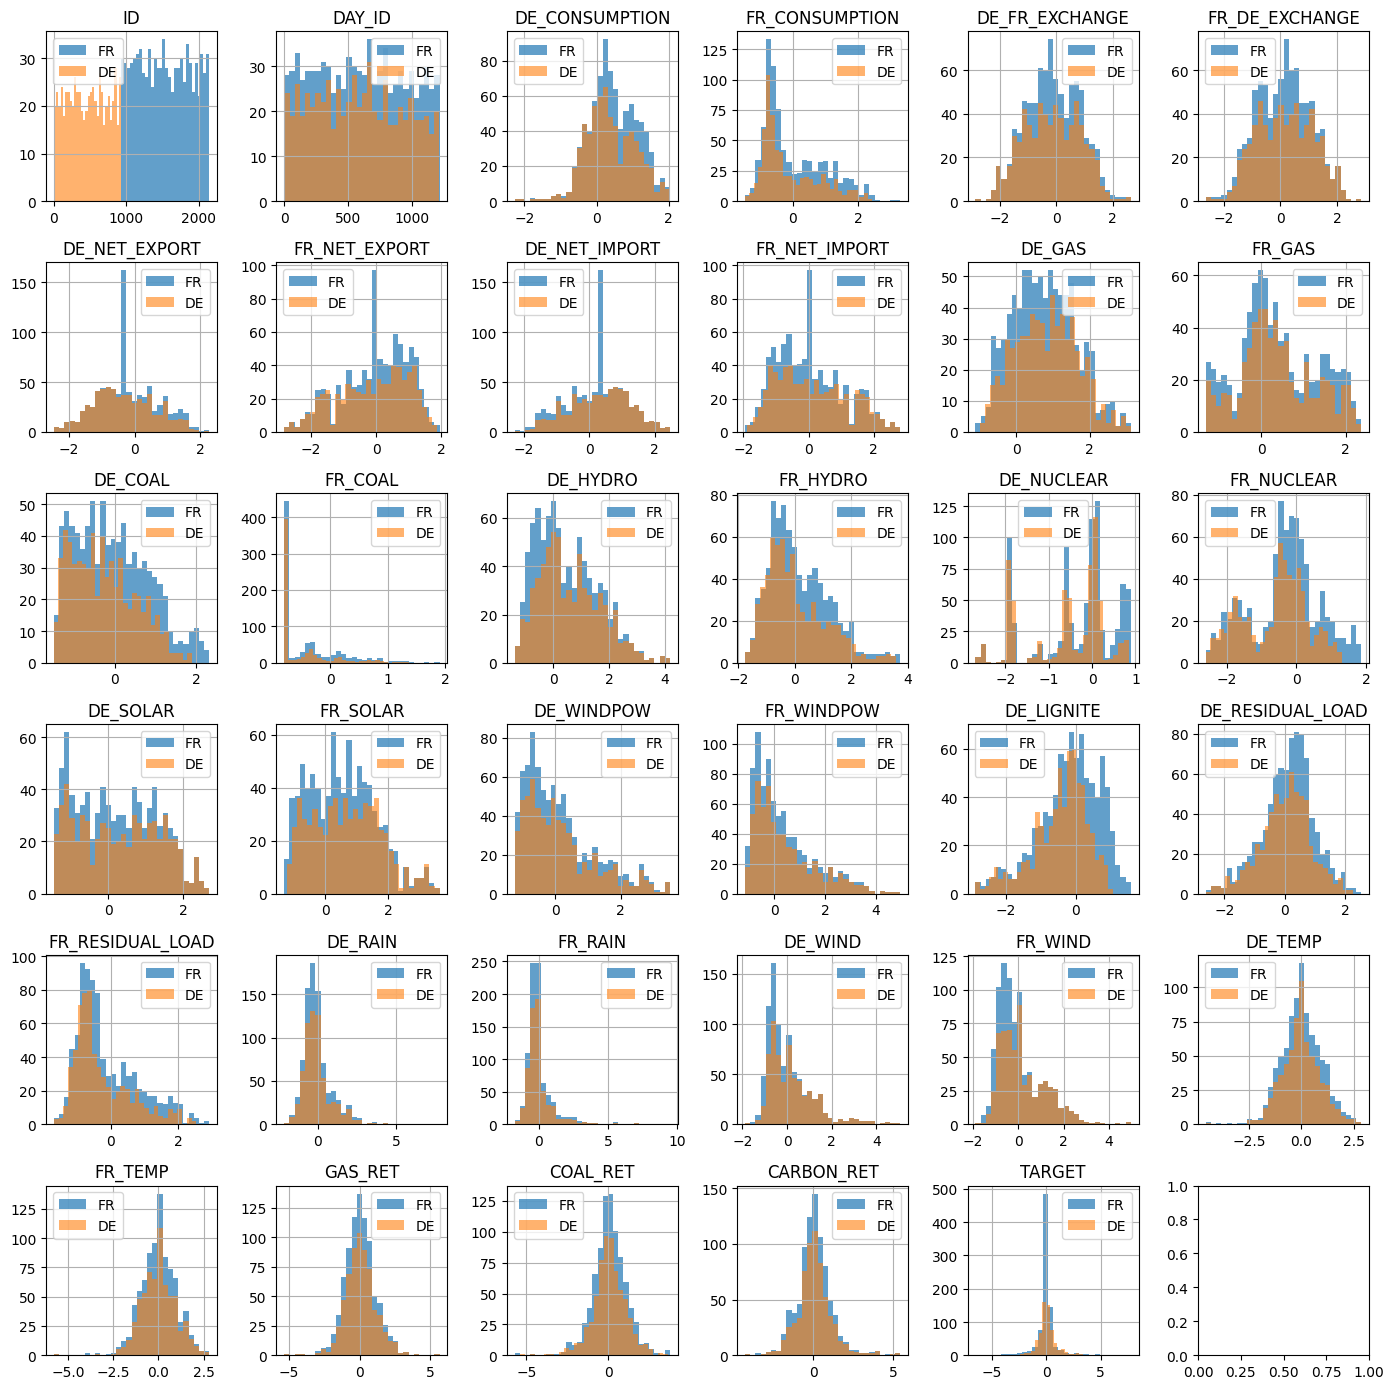

In [371]:
nb_col = 6
nb_row = - (-len(features)//6)
fig, ax = plt.subplots(nb_row, nb_col, figsize=(14,14))

for i, feature in enumerate(features):
    i_col = i % nb_col
    i_row = i // nb_col
    ax1 = ax[i_row, i_col]
    
    ax1.set_title(feature)
    ax1.grid()
    df_fr[feature].hist(bins= 30, ax=ax1, alpha=0.7, label= "FR")
    df_de[feature].hist(bins= 30, ax=ax1, alpha=0.6, label= "DE")
    ax1.legend()

plt.tight_layout()

We observe that the **distributions of various features** are generally similar between **France** and **Germany**. However, it is notable that the data associated with **Germany** exhibit greater **variability** across several variables. This can be attributed to a more **comprehensive** and **dense database** on the French side.  

It could be relevant to separate the data into **two distinct sets** to develop **specific models** for each country. Indeed, the **economic differences** between France and Germany are significant and can influence their respective behaviors, particularly regarding **electricity prices**. These differences are attributable to several factors, including:  

- **The structure of the energy mix**: France relies heavily on **nuclear energy**, whereas Germany has gradually reduced its use of nuclear energy in favor of **renewable sources** such as wind and solar. This creates differing dynamics in electricity supply and **sensitivity to weather conditions**.  

- **Energy policies**: The energy strategies differ between the two countries, with a faster energy transition in **Germany**, accompanied by **subsidy and regulatory policies** to promote renewables. In France, dependence on nuclear energy leads to a policy focus on **supply stability**.  

- **Climatic and geographical conditions**: Climatic variations, such as differences in **temperature** and **precipitation**, differently affect energy consumption in each country. For instance, France may experience higher heating demand in winter, while Germany, with its significant **wind power infrastructure**, is more impacted by wind variations.  

These differences suggest that a single model might not adequately capture the unique dynamics of each country. Therefore, an approach using **separate models** for **France** and **Germany** could better reflect their economic and energy-specific characteristics.


### Analysis of Data Availability 

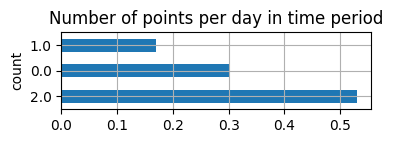

In [ ]:
F = df.DAY_ID.value_counts().sort_index()
F = F.reindex(range(F.index.max()))
F = F.fillna(0)
F = F.value_counts()
F /= F.sum()
fig, ax = plt.subplots(figsize=(4,1))
ax1 = ax
ax1.set_title("Number of points per day in time period")
F.plot(kind="barh", ax=ax1)
ax1.grid()

The distribution of days based on data availability (53% of days with data for both countries, 30% without data, and the remainder with partial data available for only one of the two countries) provides important insights into the quality and representativeness of the sample used in our analysis.  

This distribution highlights the need to adopt strategies for handling missing data. Two approaches can be considered:  

- **Separate models by country** for days where data is available for only one country.  
- **Imputation or exclusion of days without data**, depending on their proportion and the potential impact on the analysis.  

These observations call for caution when interpreting the results, as irregular data availability may affect conclusions regarding temporal phenomena or direct comparisons between France and Germany.



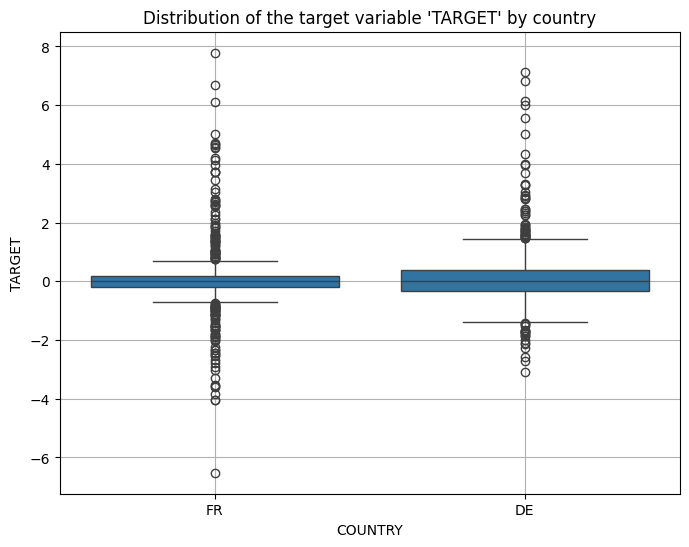

In [6]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="COUNTRY", y="TARGET", data=df)
plt.title("Distribution of the target variable 'TARGET' by country")
plt.xlabel("COUNTRY")
plt.ylabel("TARGET")
plt.grid(True)
plt.show()

Examining the distribution of the target variable for both countries reveals that the median is similar and close to zero for both France and Germany. This suggests that the target values are well **centered around zero** in both cases, indicating a generally balanced distribution of positive and negative values. This centrality can be interpreted as follows:  

- **Absence of trend bias**: The proximity of the median to zero for both countries suggests there is no systematic bias in the target values. In other words, the values do not skew significantly toward positive or negative levels, which is favorable for comparative analyses or symmetric predictive models.  
- **Quantile**: The interquartile range is slightly narrower for France, meaning that most TARGET values are more concentrated around the median compared to Germany. However, the presence of numerous outliers in Francesignificantly extends the range of extreme values, potentially requiring special handling to prevent undue influence on the models.  

#### Presence of Outliers  

Another striking aspect is the presence of **numerous outliers in the French data**, whereas extreme values are less frequent in Germany. This could reflect several dynamics:  

- **Increased variability in French data**: The higher frequency of extreme values in France might indicate greater volatility in the market or factors influencing the target variable.  
- **Influence of country-specific conditions**: France and Germany differ in infrastructure and energy mix (e.g., France's heavier reliance on nuclear energy compared to Germany). These structural differences could lead to extreme variations in certain energy indicators, especially during crises or periods of exceptional demand.  
- **Potential impact on predictive models**: These outliers could complicate modeling for the French data. Extreme values might influence the mean and variance, which could affect models sensitive to significant deviations. Techniques for managing outliers (e.g., data transformation or smoothing extreme values) may be necessary to enhance model robustness.  

#### Implications for Analysis  

The observations regarding centrality and outliers have several implications for analysis and modeling:  

1. **Strategies for managing extreme values**: The outliers in the French data may require special handling, such as outlier removal or the application of normalization or logarithmic transformation techniques to reduce their impact.  
2. **Country-specific approaches**: Since the target variable's distribution differs between France and Germany (particularly regarding outliers), it may be advisable to build separate models or apply differentiated preprocessing for each country.  
3. **Use of robust models**: In the presence of numerous outliers, more robust models, such as those based on the median (quantile regression) or ensemble algorithms (e.g., random forest or gradient boosting), might be better suited than standard linear models.  

#### Summary  

Although the French and German distributions of the target variable exhibit similar centrality, the higher frequency of outliers in France calls for a cautious approach. Proper handling of these outliers is essential to ensure the quality of results and the robustness of predictive models.


### Pearson's Correlation Matrix

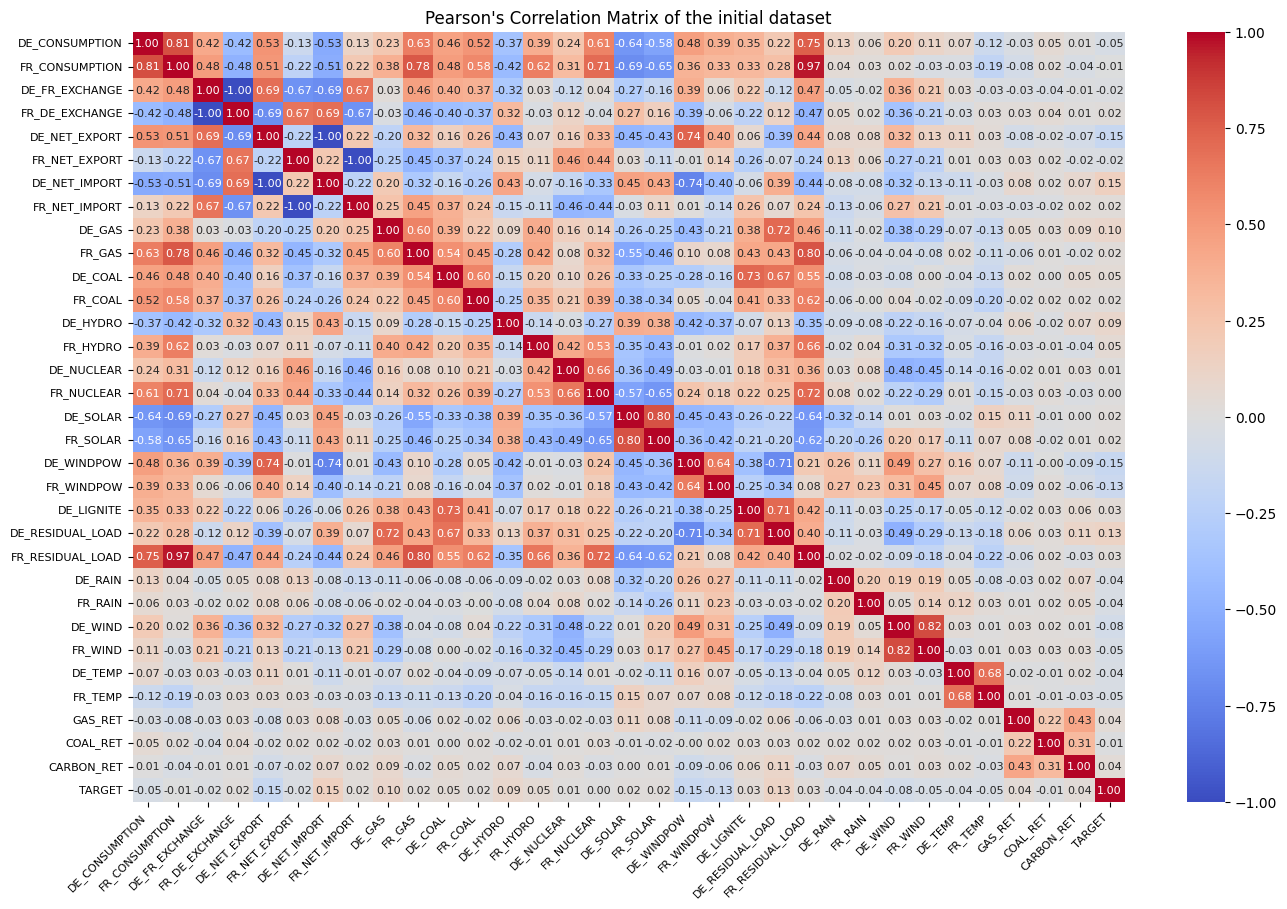

In [ ]:
plt.figure(figsize=(16, 10))
df_cleaned = df_general.drop(columns=['ID', 'DAY_ID','COUNTRY'])
pearson_corr = df_cleaned.corr(method='pearson')
sns.heatmap(pearson_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, annot_kws={"size": 8})
plt.title("Pearson's Correlation Matrix of the initial dataset")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.show()


### Spearman's Correlation Matrix

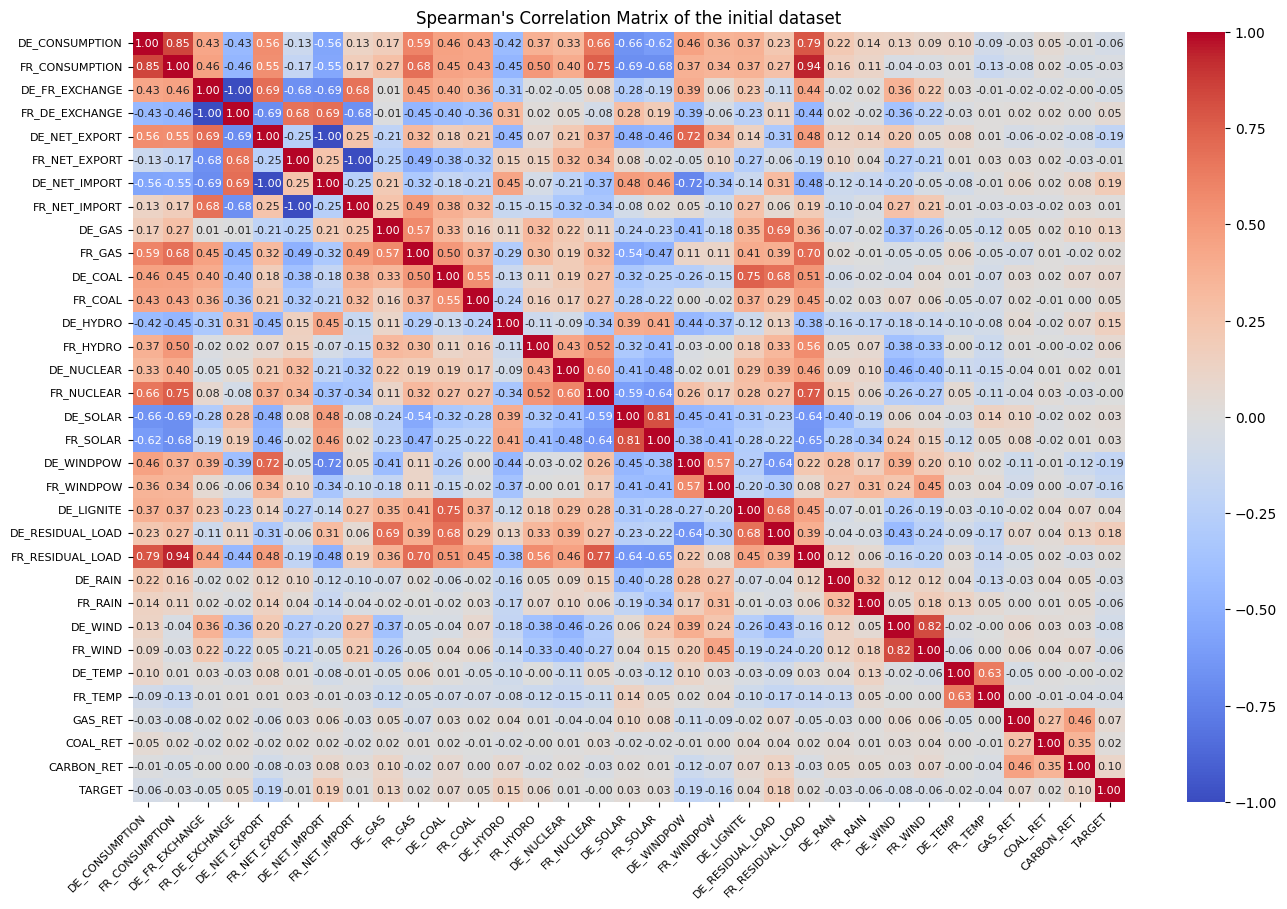

In [ ]:
plt.figure(figsize=(16, 10))
df_cleaned = df.drop(columns=['ID', 'DAY_ID','COUNTRY'])
spearman_corr = df_cleaned.corr(method='spearman')
sns.heatmap(spearman_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, annot_kws={"size": 8})
plt.title("Spearman's Correlation Matrix of the initial dataset")   
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.show()

By examining the **correlation matrices**, it is noticeable that the **Spearman** matrix shows stronger correlations with the '**TARGET**' row compared to the **Pearson** matrix. This difference arises because **Spearman** evaluates the **monotonic relationship** between variables, whether linear or not, based on their **ranks** rather than their absolute values. This method better captures relationships when the data is **nonlinear** or contains **outliers**, which might distort the **Pearson** correlation.


### Energy Production Distribution by Country

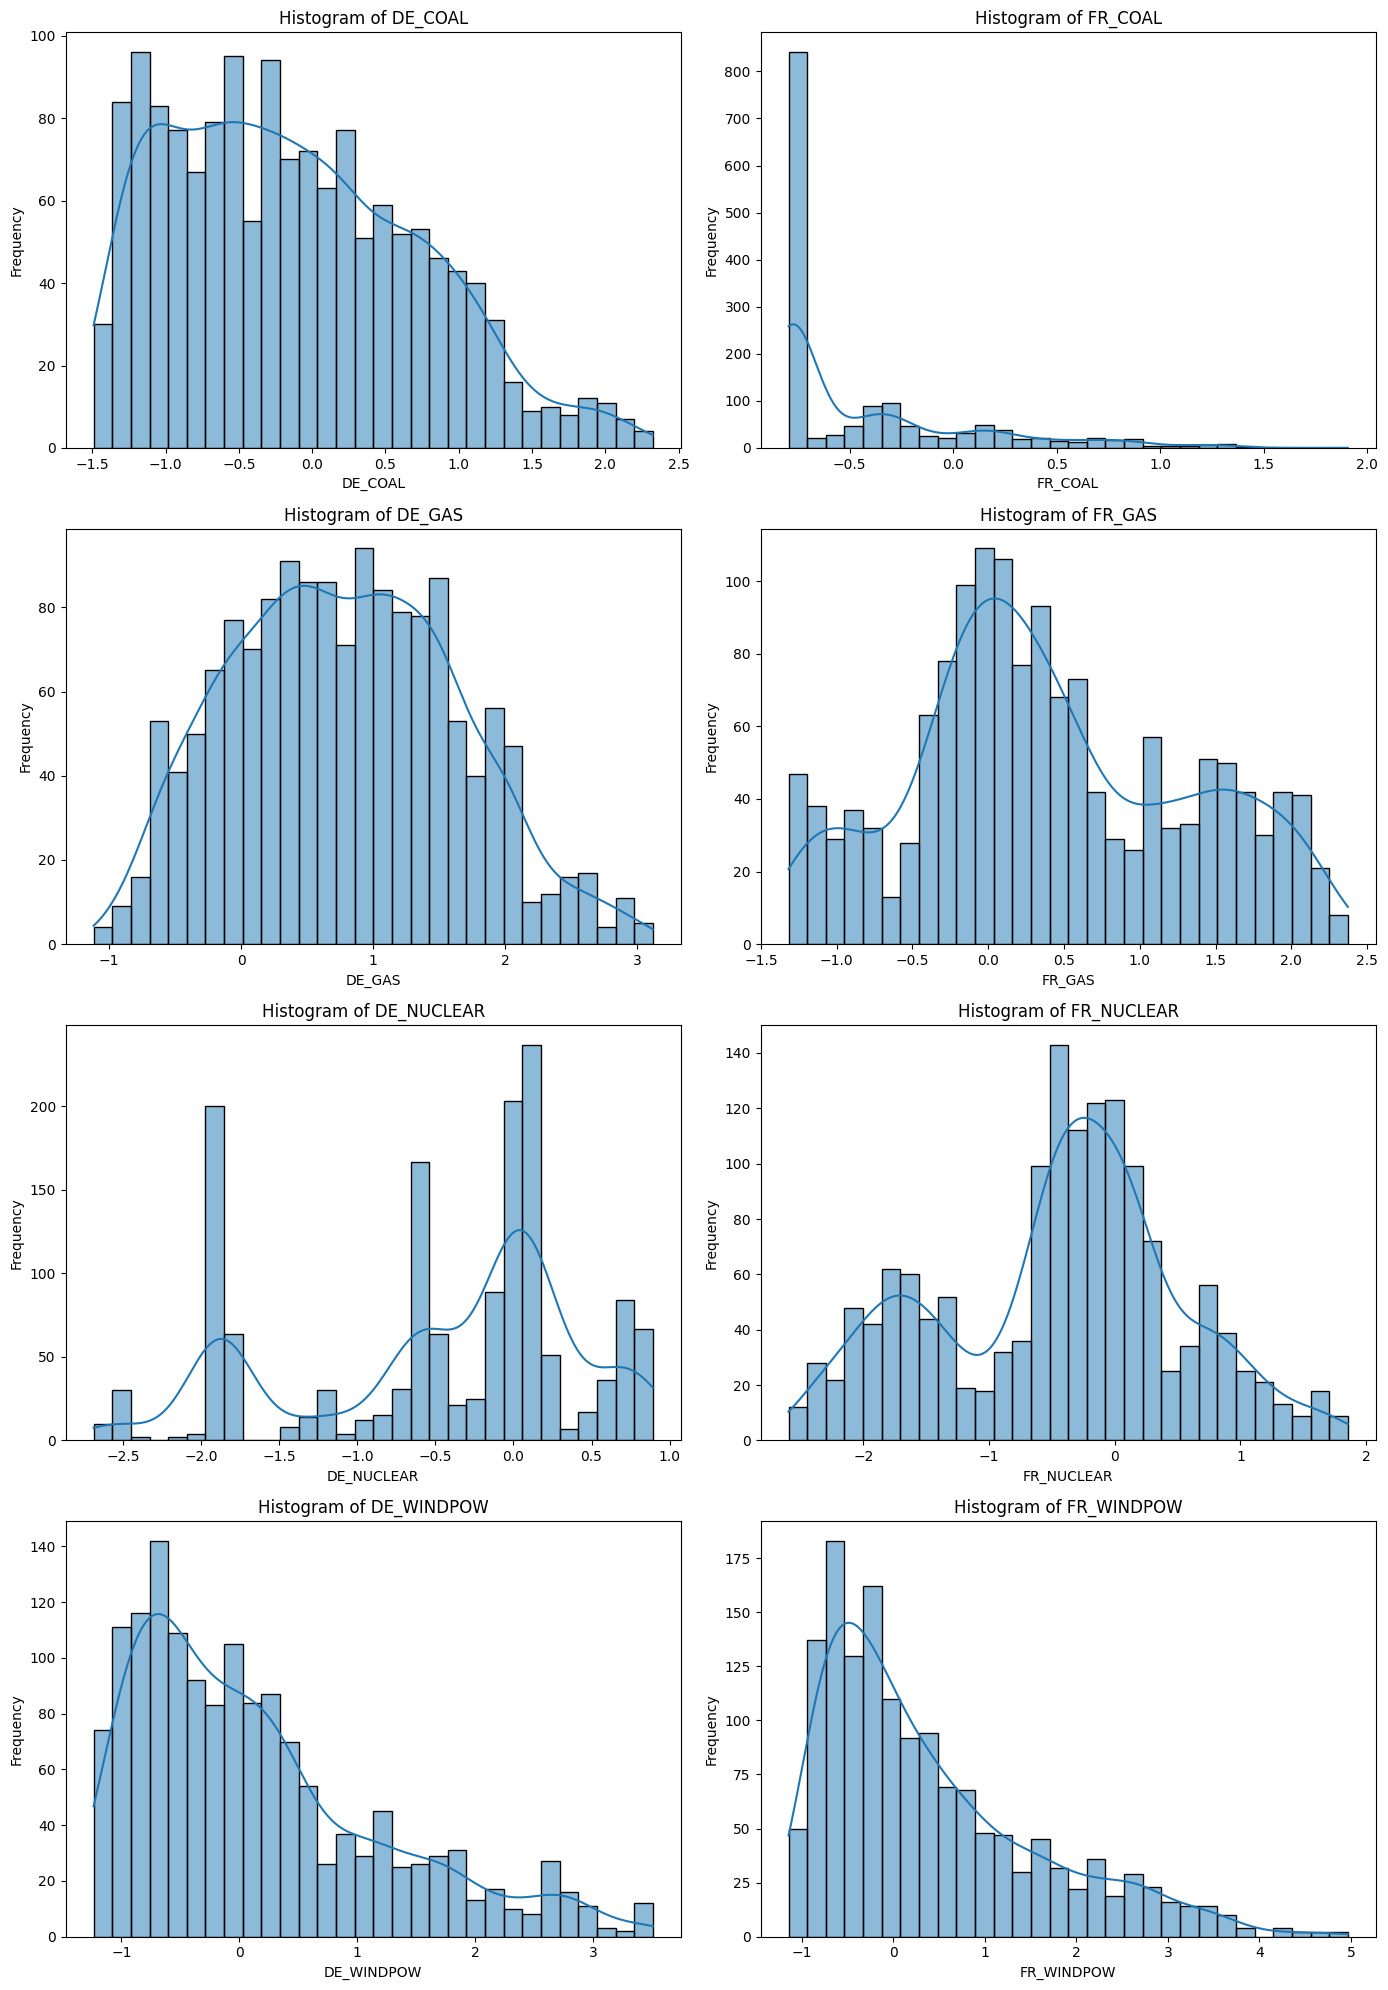

In [ ]:
energy_sources = ['DE_COAL', 'FR_COAL', 'DE_GAS', 'FR_GAS', 'DE_NUCLEAR', 'FR_NUCLEAR', 'DE_WINDPOW', 'FR_WINDPOW']

n_rows = len(energy_sources) // 2

plt.figure(figsize=(14, n_rows * 5))

for i, source in enumerate(energy_sources, 1):
    plt.subplot(n_rows, 2, i)
    sns.histplot(df_general[source], bins=30, kde=True)
    plt.title(f'Histogram of {source}')
    plt.xlabel(source)
    plt.ylabel('Frequency')
    
plt.tight_layout()
plt.show()

These charts demonstrate that while certain energy sources, such as **wind power**, appear to be similarly distributed between **France** and **Germany**, the two countries clearly adopt **distinct energy strategies**. Notably, **France** stands out for its greater **stability** in **nuclear energy** production, while it remains relatively **weak** in terms of **coal** production.


### Spearman's Correlation Matrix for Data Related to France  

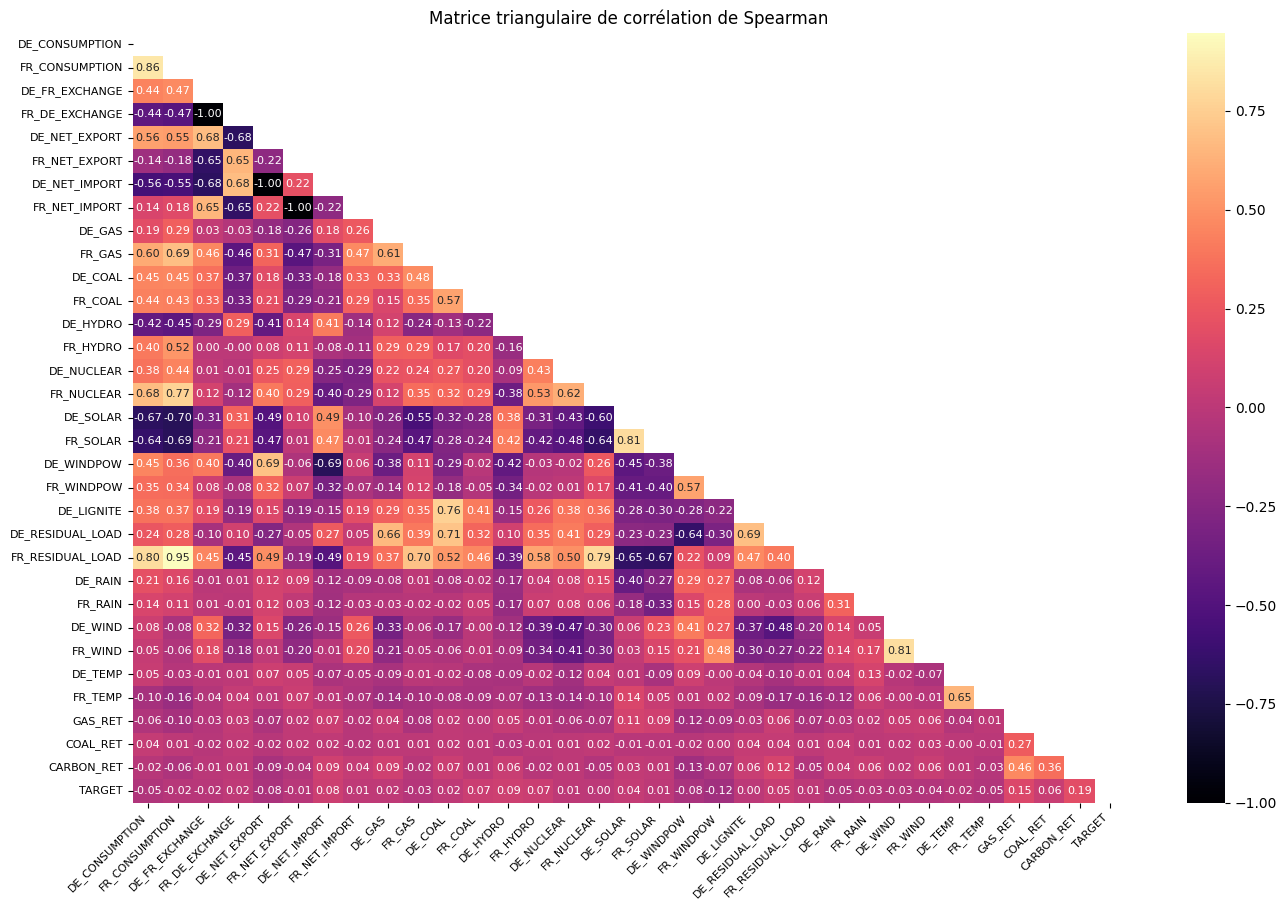

In [ ]:
df_fr_cleaned=df_fr.drop(['ID','DAY_ID'],axis=1)
corr_matrix = df_fr_cleaned.corr()
plt.figure(figsize=(16, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
spearman_corr = df_fr_cleaned.corr(method='spearman')
sns.heatmap(spearman_corr, annot=True,mask=mask, fmt=".2f", cmap="magma", cbar=True, annot_kws={"size": 8})
plt.title("Matrice triangulaire de corrélation de Spearman")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.show()

### Spearman Correlation Matrix for Data Related to Germany 

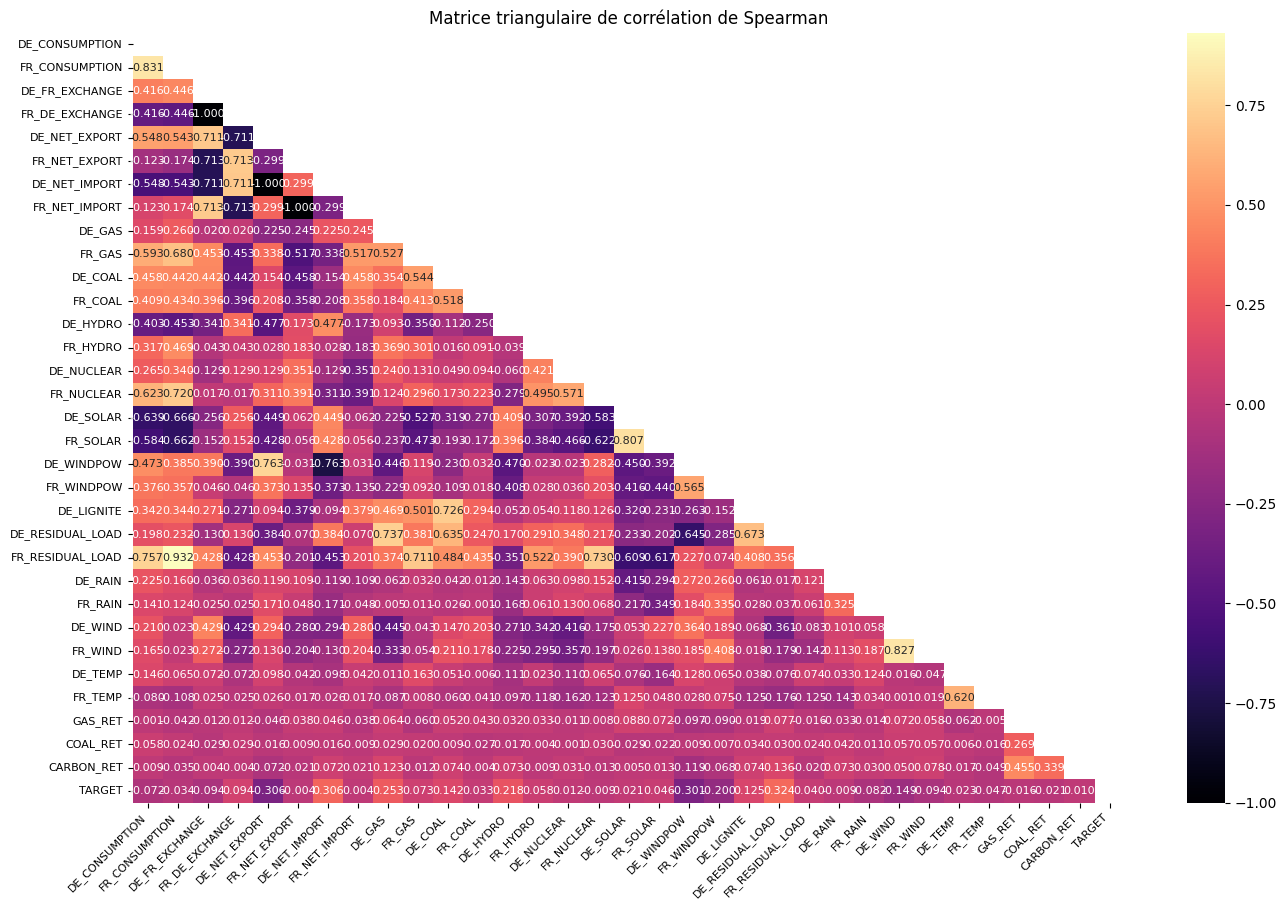

In [ ]:
df_de_cleaned=df_de.drop(['ID','DAY_ID'],axis=1)
corr_matrix = df_de_cleaned.corr()
plt.figure(figsize=(16, 10))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

spearman_corr = df_de_cleaned.corr(method='spearman')
sns.heatmap(spearman_corr,mask=mask, annot=True, fmt=".3f", cmap="magma", cbar=True, annot_kws={"size": 8})
plt.title("Matrice triangulaire de corrélation de Spearman")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.show()

## Model Evaluation

### Spearman's Correlation in Our Project

In this project, we aim to explain daily variations in electricity futures prices in Europe. Given the complex and non-linear relationships between factors like energy production, weather conditions, and market prices, **Spearman's correlation** is a suitable tool to evaluate our model's performance, alongside other metrics like R², MAE, and MSE.

### Why Use Spearman?

1. **Monotonicity**: The relationships between variables, such as the impact of gas prices on electricity prices, may be monotonic but non-linear. Spearman captures these monotonic trends where Pearson would fail.

2. **Robustness to Outliers**: Since the data can contain extreme values (e.g., sudden price spikes), Spearman is less sensitive to outliers, providing a more stable evaluation.

3. **Capturing Non-linear Relationships**: Variables like renewable energy production or electricity exchanges may have a non-linear effect. Spearman helps measure the monotonic relationship, even if it's not strictly linear.

### Spearman's Rank Correlation Formula

The Spearman rank correlation coefficient ($\rho$) is calculated as:

$$
\rho = 1 - \frac{6 \sum d_i^2}{n(n^2 - 1)}
$$

Where:
- $d_i$ is the difference between the ranks of corresponding values in the two datasets.
- $n$ is the total number of data pairs.

### Additional Evaluation Metrics

- **R²**: This metric tells us the proportion of the variance in the target variable (electricity prices) explained by the model. A higher R² indicates a better fit.
  
- **MAE (Mean Absolute Error)**: This measures the average magnitude of errors in predictions, providing insight into how close the model's predictions are to the actual values, with smaller values being preferable.
  
- **MSE (Mean Squared Error)**: This gives us the squared average of the model's prediction errors, emphasizing larger errors more heavily. Like MAE, smaller values indicate better model performance.

Spearman's correlation is ideal for our project because it allows us to evaluate complex, non-linear trends in electricity prices while being robust to outliers. Alongside Spearman, we also use R², MAE, and MSE to provide a comprehensive view of our model's performance and ensure it captures the underlying dynamics of the electricity market effectively.


### K-Fold Cross-Validation and Model Evaluation

We use **k-fold cross-validation** to assess model performance on multiple data splits. The procedure involves:

1. **Data Preparation**: Features (`X`) and target (`y`) are separated from the dataset.
2. **K-Fold Cross-Validation**: Data is split into `k` folds, with each fold used for testing once.
3. **Standardization**: Features are scaled to have zero mean and unit variance using **StandardScaler**.
4. **Model Training**: The model is trained on the training data and predictions are made on the test set.
5. **Evaluation Metrics**: We calculate **Spearman's correlation**, **R²**, **MAE**, and **MSE** to assess model accuracy.
6. **Result Aggregation**: Metrics from each fold are collected in a DataFrame and returned.

This method provides a robust evaluation of the model’s performance across different subsets of data.


In [ ]:
from sklearn.model_selection import KFold
# Import timeseries split
from sklearn.model_selection import TimeSeriesSplit

def kfoldCrossValidation(df, M, k):
    X = df.drop(columns=['ID', 'TARGET'], errors='ignore')
    y = df['TARGET']

    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    result = pd.DataFrame(columns=['Spearman', 'R2', 'MAE', 'MSE'])
  
    X = np.array(X)
    y = np.array(y)
  
    # Cross-validation loop
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X[train_index], X[test_index]     
        y_train, y_test = y[train_index], y[test_index]

        # Data Standardization
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Training and prediction   
        M.fit(X_train, y_train)
        y_pred_test = M.predict(X_test)
    
        # Metrics calculation
        result_temp = pd.DataFrame([{
            'Spearman': spearmanr(y_test, y_pred_test).correlation, 
            'R2': M.score(X_test, y_test), 
            'MAE': np.mean(np.abs(y_test - y_pred_test)), 
            'MSE': np.mean((y_test - y_pred_test) ** 2)
        }])
    
        if not result_temp.isna().all().all():  
            result = pd.concat([result, result_temp], ignore_index=True)
    
    return result, y_test, y_pred_test


## Aggregation Model Function



Since we have separate models for each country, a function is required to aggregate the predictions from these two distinct machine learning models, each designed specifically to predict electricity prices in France and Germany. Each model is developed independently to account for the unique market dynamics, energy sources, and economic factors in each country.

### 1. Split the dataset by Country

The function split_dataset_by_country, which takes the original dataset as a parameter, enables splitting the dataset into two new datasets: df_fr (for the rows concerning France) and df_de (for the rows concerning Germany).

In [ ]:
def split_dataset_by_country(df):
    df_fr = df[df['COUNTRY'] == 'FR']
    df_de = df[df['COUNTRY'] == 'DE']
    return df_fr, df_de

### 2. Drop irrelevent Columns

We decided, for each country (and thus for each model), to focus on the columns specifically related to each country. The function drop_irrelevant_columns allows us to remove the columns related to Germany from the df_fr dataset and the columns related to France from the df_de dataset.

In [ ]:
def drop_irrelevant_columns(df, country):
    if country == 'FR':
        columns_to_drop = ['COUNTRY', 'DE_CONSUMPTION', 'DE_FR_EXCHANGE', 'FR_NET_EXPORT',
                           'DE_NET_EXPORT', 'DE_NET_IMPORT', 'DE_GAS', 'DE_COAL', 'DE_HYDRO',
                           'DE_NUCLEAR', 'DE_SOLAR', 'DE_WINDPOW', 'DE_LIGNITE', 'DE_RESIDUAL_LOAD',
                           'DE_RAIN', 'DE_WIND', 'DE_TEMP']
    elif country == 'DE':
        columns_to_drop = ['COUNTRY', 'FR_CONSUMPTION', 'FR_DE_EXCHANGE', 'DE_NET_EXPORT',
                           'FR_NET_EXPORT', 'FR_NET_IMPORT', 'FR_GAS', 'FR_COAL', 'FR_HYDRO',
                           'FR_NUCLEAR', 'FR_SOLAR', 'FR_WINDPOW', 'FR_RESIDUAL_LOAD',
                           'FR_RAIN', 'FR_WIND', 'FR_TEMP']
        
    columns_to_drop = [col for col in columns_to_drop if col in df.columns]

    return df.drop(columns=columns_to_drop)

### 3. Fill Missing Values

Each dataset contains a certain number of missing values (as previously noted), and given the relatively limited amount of data, we couldn’t simply remove the rows with missing values. Therefore, we use the fill_missing_values function on df_fr and df_de individually to replace the missing values with the average of the column where the missing value is located.

In [ ]:
def fill_missing_values(df):
    return df.fillna(df.mean())

### 4. Merging the results

Although we trained models and made predictions separately for France and Germany, the final model to submit at the end of the challenge is a single model. The function combine_results allows us to test the previous metrics, but this time on the entire set of our predictions.

In [382]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

def combine_results(y_test_fr, y_pred_fr, y_test_de, y_pred_de):
    y_pred_fr = pd.Series(y_pred_fr)
    y_pred_de = pd.Series(y_pred_de)
    y_test_de = pd.Series(y_test_de)
    y_test_fr = pd.Series(y_test_fr)
    
    y_true_combined = pd.concat([y_test_fr, y_test_de], axis=0)
    y_pred_combined = pd.concat([pd.Series(y_pred_fr), pd.Series(y_pred_de)], axis=0)
    combined_r2 = r2_score(y_true_combined, y_pred_combined)
    combined_mse = mean_squared_error(y_true_combined, y_pred_combined)
    combined_spearman = spearmanr(y_true_combined, y_pred_combined).correlation
    combined_mae = np.mean(np.abs(y_true_combined - y_pred_combined))   
    return combined_r2, combined_mse, combined_mae, combined_spearman

### 5. Final Function

Finally, we implement our global function, which sequentially utilizes the previously defined functions (1 to 4). This function provides the model's performance metrics for France, Germany, and the entire dataset.

The parameters "FeatureEngineering" and "DropIrrelevantColumns" will be applied later, and we will provide an explanation at that time.

In [383]:
def Final_model(df, model_fr, model_de,FeatureEngineering=None, DropIrrelevantColumns=True):

    # Step 1 : datasets splitting
    df_fr, df_de = split_dataset_by_country(df)

    if FeatureEngineering is None:
        if DropIrrelevantColumns: 
            df_fr = drop_irrelevant_columns(df_fr, 'FR')
            df_de = drop_irrelevant_columns(df_de, 'DE')
        else:
            df_fr = df_fr.drop(columns=['COUNTRY'])
            df_de = df_de.drop(columns=['COUNTRY'])

    else:
        df_fr = df_fr.drop(columns=['COUNTRY'])
        df_de = df_de.drop(columns=['COUNTRY'])
        df_fr, df_de = FeatureEngineering(df_fr,df_de)

    # Step 3 : Missing values replacement
    df_fr = fill_missing_values(df_fr)
    df_de = fill_missing_values(df_de)

    result_fr, y_test_fr, y_pred_fr = kfoldCrossValidation(df_fr, model_fr, 6)
    result_de, y_test_de, y_pred_de = kfoldCrossValidation(df_de, model_de, 6)

    # Step 8 : Combining the results and evaluating
    combined_r2, combined_mse, combined_mae, combined_spearman = combine_results(y_test_fr, y_pred_fr, y_test_de, y_pred_de)
    result_global = pd.DataFrame([{
        'R2': combined_r2,
        'MSE': combined_mse,
        'MAE': combined_mae,
        'Spearman': combined_spearman
    }])

    return result_fr, result_de, result_global

## First Model Using Linear Regression

### Model only with country separation

Building on our prior efforts, it’s now straightforward to test and evaluate different models.

Training of a model using simple LinearRegression

In [384]:
result_basic = Final_model(df, LinearRegression(), LinearRegression(), DropIrrelevantColumns=False)
result_basic[2]

,R2,MSE,MAE,Spearman
0,0.010465,1.533205,0.682168,0.213655


We observe that our Spearman correlation, R², and MSE scores are relatively low. However, it's crucial to consider the context. In financial markets, price movements are influenced by thousands of factors with complex, non-linear relationships, making it nearly impossible to develop a model that fully explains electricity prices today. For reference, the best model from the ENS QRT challenge addressing this problem achieved a Spearman correlation of 0.6. Our objective is to enhance these evaluation metrics as much as possible.

Display the results by country:

In [385]:
print("Results for France:")
print(result_basic[0],"\n")
print("Mean results for France:")
result_basic[0].mean()

Results for France:
   Spearman        R2       MAE       MSE
0 -0.007559 -0.110539  0.595226  1.381962
1  0.182659  0.039028  0.589862  0.975638
2  0.146635 -0.106983  0.410361  0.616250
3  0.046964 -0.060798  0.512673  0.785875
4  0.243188  0.011558  0.613994  1.120448
5  0.113663 -0.007220  0.660736  1.576164 

Mean results for France:


Spearman    0.120925
R2         -0.039159
MAE         0.563809
MSE         1.076056
dtype: float64

In [ ]:
print("Results for Germany:")
print(result_basic[1],"\n")
print("Mean results for Germany:")
result_basic[1].mean()

Results for Germany:
   Spearman        R2       MAE       MSE
0  0.412768  0.027478  0.609882  1.034000
1  0.237132 -0.032349  0.671709  1.151958
2  0.392504  0.069996  0.568098  0.693241
3  0.359480  0.053854  0.591959  0.879589
4  0.351721  0.028264  0.695886  1.141325
5  0.345971  0.033569  0.710409  1.476597 

Mean results for Germany:


Spearman    0.349929
R2          0.030135
MAE         0.641324
MSE         1.062785
dtype: float64

As observed previously, it comes as no surprise that the German model outperforms the French one. This aligns with our earlier findings, where the features in the German dataset exhibited higher Spearman and Pearson correlation scores compared to those in the French dataset. Consequently, our model demonstrates better performance in Germany than in France.

### Model with separation and deleting of useless column for each country

Next, we explore whether the model's performance improves when features specific to France are removed for the German model, and vice versa. This is accomplished using the `DropIrrelevantColumns` function, which handles the removal of these features.

In [386]:
result = Final_model(df,LinearRegression(), LinearRegression(), DropIrrelevantColumns=True)
print("Results for the overall data:")
result[2]

Results for the overall data:


,R2,MSE,MAE,Spearman
0,0.021444,1.516196,0.66095,0.228314


We observe a slightly improved score after applying this approach, so we will retain it for the remainder of the project.

Results for each Country

In [ ]:
print("Results for France:")
print(result[0],"\n")
print("Mean results for France:")
result[0].mean()

Results for France:
   Spearman        R2       MAE       MSE
0  0.095132 -0.021942  0.540903  1.271712
1  0.110415 -0.010931  0.581281  1.026360
2  0.142700 -0.045810  0.383076  0.582195
3  0.066466 -0.056812  0.484296  0.782923
4  0.184465  0.000525  0.574336  1.132955
5  0.123698 -0.007099  0.638691  1.575974 

Mean results for France:


Spearman    0.120479
R2         -0.023678
MAE         0.533764
MSE         1.062020
dtype: float64

In [ ]:
print("Results for Germany:")
print(result[1],"\n")
print("Mean results for Germany:")
result[1].mean()

Results for Germany:
   Spearman        R2       MAE       MSE
0  0.457772  0.062252  0.597822  0.997028
1  0.228090  0.005428  0.663708  1.109805
2  0.385186  0.079801  0.566646  0.685932
3  0.358412  0.090473  0.588213  0.845547
4  0.383099  0.044765  0.691887  1.121945
5  0.392474  0.059209  0.690282  1.437422 

Mean results for Germany:


Spearman    0.367506
R2          0.056988
MAE         0.633093
MSE         1.032946
dtype: float64

## Feature engineering

We want to add more columns to create more precise models so we will do some feature engineering 

We can compute rolling statistics to capture trends and fluctuations over time. 
The rolling mean smooths the data to highlight long-term trends, while the rolling standard deviation measures volatility and variability within specific time windows (weekly and monthly). 
The slope, calculated using linear regression on rolling windows, captures the rate of change or trend direction, helping to identify whether values are generally increasing or decreasing over time.

In [387]:
# Function to calculate rolling statistics (mean, std, median, min, max, slope) for DE_ and FR_ columns
def add_statistics(df, variables, windows):
    def slope(y):
        return np.polyfit(range(len(y)), y, 1)[0] if len(y) > 0 else np.nan
    
    df.order = df.sort_values(by='DAY_ID')
    
    for var in variables:
        for window in windows:
            for country in ['DE_', 'FR_']:
                col = f'{country}{var}'
                df[f'{col}_MEAN_{window}D'] = df[col].rolling(window=window).mean()
                df[f'{col}_STD_{window}D'] = df[col].rolling(window=window).std()
                df[f'{col}_MEDIAN_{window}D'] = df[col].rolling(window=window).median()
                df[f'{col}_MIN_{window}D'] = df[col].rolling(window=window).min()
                df[f'{col}_MAX_{window}D'] = df[col].rolling(window=window).max()
                df[f'{col}_SLOPE_{window}D'] = df[col].rolling(window=window).apply(slope, raw=True)
    return df


Then we can use technical indicators widely use in finance like volatility and moving averages that are used to analyze time-series data. Volatility, typically measured by rolling standard deviation, helps quantify the level of fluctuation or uncertainty in the data. Moving averages, especially exponential moving averages (EMA), are used to smooth short-term fluctuations and highlight long-term trends or cycles, making it easier to detect underlying patterns in the data.

In [ ]:
def add_indicators(df):
    for commodity in ['GAS_RET', 'COAL_RET', 'CARBON_RET']:
        df[f'{commodity}_VOLATILITY_WEEKLY'] = df[commodity].rolling(window=7).std()
        df[f'{commodity}_VOLATILITY_MONTHLY'] = df[commodity].rolling(window=30).std()
        df[f'{commodity}_EMA_MONTHLY'] = df[commodity].ewm(span=30, adjust=False).mean()
    
    return df

Finally we can add column specific with this domain area such as energy ratios, weather effects, and clustering, wich will provide further insights into underlying patterns. Weather effects, such as temperature or wind, are crucial in energy demand prediction, as they directly influence consumption and production.

In [ ]:
# Function to add energy source ratios and effects
def add_energy(df):
    energy_sources = ['GAS', 'COAL', 'HYDRO', 'NUCLEAR', 'SOLAR', 'WINDPOW']
    
    for country in ['DE_', 'FR_']:
        total_energy = sum(df[f'{country}{source}'] for source in energy_sources)
        
        for source in energy_sources:
            df[f'{country}{source}_RATIO'] = df[f'{country}{source}'] / total_energy

        df[f'{country}WIND_SOLAR'] = df[f'{country}WINDPOW'] + df[f'{country}SOLAR']
        df[f'{country}TEMP_EFFECT'] = df[f'{country}TEMP'] * df[f'{country}CONSUMPTION']
        df[f'{country}WIND_EFFECT'] = df[f'{country}WIND'] * df[f'{country}WINDPOW']
        df[f'{country}SOLAR_EFFECT'] = (df[f'{country}SOLAR'] / df[f'{country}TEMP']).replace([np.inf, -np.inf], np.nan).fillna(0)
    
    return df

Now that we have rearrange all our functions to add columns we can create a single function that call the others

In [ ]:
# Main function to add custom features by combining all the previous functions
def add_columns(df):
    periods=[7, 30]# Weekly and Monthly
    variables = ['CONSUMPTION', 'GAS', 'COAL', 'HYDRO', 'NUCLEAR', 'SOLAR', 'WINDPOW', 'TEMP', 'RAIN', 'WIND']

    df=add_statistics(df, variables, periods)
    df=add_energy(df)
    df=add_indicators(df)
    
    df.fillna(df.mean(), inplace=True)
    return df

The following function calculates the correlation matrix and selects features that are either highly correlated with each other or have low correlation with the target variable. It combines both conditions to decide which features to drop

In [ ]:
def select_features_based_on_correlation(df, target_column, multicollinear_threshold, correlation_threshold):
    # Calculate the Spearman correlation matrix because it is the metric that we choose
    corr_matrix=df.corr(method='spearman')
    # Identify columns that are highly correlated with each other
    # (excluding the target variable correlation)
    high_corr_var=np.where(corr_matrix > multicollinear_threshold)
    high_corr_var=[(corr_matrix.index[x], corr_matrix.columns[y]) 
                     for x, y in zip(*high_corr_var) 
                     if x!=y and x < y]
    # Extract the names of columns to drop based on multicollinearity
    multicollinear_features=set([item for sublist in high_corr_var for item in sublist])
    # Identify features that have a low correlation with the target variable
    low_corr_with_target=corr_matrix[target_column][abs(corr_matrix[target_column]) < correlation_threshold].index.tolist()
    # Combine features to drop due to multicollinearity and low correlation with target
    features_to_drop=multicollinear_features.union(low_corr_with_target)
    # Determine the final list of features to keep
    features_to_keep=[feature for feature in df.columns if feature not in features_to_drop and feature!=target_column]
    
    return features_to_keep

Here, we filter the dataset for France (COUNTRY == 'FR'), remove certain columns, and keep some of the original columns, which can still have an impact on our prediction even if they are less correlated than the ‘artificial’ columns from feature engineering.

### Final function that will be used for the feature engineering

In [388]:
def FeatureEngineering(df_fr, df_de, df_fr_test=None, df_de_test=None):

    # We retain the columns in the main dataset, but not the columns with a high correlation with the others or a lower correlation with TARGET
    col_fr_best = select_features_based_on_correlation(df_fr, 'TARGET', 0.93, 0.08)

    # Select columns that do not start with 'DE' (to avoid mixing German data)
    df_no_de = df_fr[df_fr.columns[~df_fr.columns.str.startswith('DE')]]
    col_fr = [col for col in df_no_de.columns if col in col_fr_best]
    df_fr.fillna(df_fr.mean(), inplace=True)
    df_fr_test.fillna(df_fr_test.mean(), inplace=True) if df_fr_test is not None else None

    # We retain the columns in the main dataset, but not the columns with a high correlation with the others or a lower correlation with TARGET
    col_de_best = select_features_based_on_correlation(df_de, 'TARGET', 0.93, 0.08)

    # Select columns that do not start with 'FR' (to avoid mixing French data)
    df_no_fr = df_de[df_de.columns[~df_de.columns.str.startswith('FR')]]
    col_de = [col for col in df_no_fr.columns if col in col_de_best]
    df_de.fillna(df_de.mean(), inplace=True)
    df_de_test.fillna(df_de_test.mean(), inplace=True) if df_de_test is not None else None

    original_fr = df_fr[col_fr]
    original_de = df_de[col_de]

    # Apply feature engineering
    df_fr = add_columns(df_fr)
    df_de = add_columns(df_de)

    if df_fr_test is not None:
        original_fr_test = df_fr_test[col_fr]
        df_fr_test = add_columns(df_fr_test)
    
    if df_de_test is not None:
        original_de_test = df_de_test[col_de]
        df_de_test = add_columns(df_de_test)

    # Select the best columns based on correlation
    best_features_fr = select_features_based_on_correlation(df_fr, 'TARGET', 0.8, 0.08)
    best_features_de = select_features_based_on_correlation(df_de, 'TARGET', 0.8, 0.15)

    # Keep the selected columns while adding the original columns
    df_fr = pd.concat([original_fr, df_fr[best_features_fr+['TARGET']]], axis=1)
    df_de = pd.concat([original_de, df_de[best_features_de+['TARGET']]], axis=1)

    df_fr_test = pd.concat([original_fr_test, df_fr_test[best_features_fr]], axis=1) if df_fr_test is not None else None
    df_de_test = pd.concat([original_de_test, df_de_test[best_features_de]], axis=1) if df_de_test is not None else None

    if df_fr_test is not None and df_de_test is not None:
        return df_fr, df_de, df_fr_test, df_de_test
    else:
        return df_fr, df_de

## Model Using LinearRegression and Feature Engineering

#### Linear Regression

In [394]:
result = Final_model(df,LinearRegression(), LinearRegression(),FeatureEngineering, DropIrrelevantColumns=True)
result[2]

,R2,MSE,MAE,Spearman
0,0.035883,1.493822,0.636906,0.297179


The Speaman Correlation improved a lot from 0.22 to almost 0.3. The features engineering give a better performance to our Model.

In [374]:
result[0].mean()

Spearman    0.184060
R2         -0.007505
MAE         0.526442
MSE         1.050891
dtype: float64

In [375]:
result[1].mean()

Spearman    0.370503
R2          0.047666
MAE         0.625838
MSE         1.032453
dtype: float64

## Model Using RandomForestRegressor

Let's experiment with the **RandomForestRegressor**, which is highly effective for capturing non-linear relationships. To maximize its potential, we use **GridSearchCV**, a technique that systematically tests multiple combinations of hyperparameters for the Random Forest and selects the best configuration for our model.

In [396]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

rf = RandomForestRegressor(random_state=42)

grid_search_1 = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search_2 = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)

result = Final_model(df, grid_search_1, grid_search_2, FeatureEngineering, True)


In [397]:
print("GridSearchCV_1 coeffcients :", grid_search_1.best_params_)
print("GridSearchCV_2 coeffcients :", grid_search_2.best_params_)

GridSearchCV_1 coeffcients : {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
GridSearchCV_2 coeffcients : {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}


In [398]:
result[2]

,R2,MSE,MAE,Spearman
0,0.068241,1.443687,0.637773,0.304045


The **RandomForestRegressor** demonstrates a markedly higher Spearman Correlation score compared to **Linear Regression**, highlighting its enhanced ability to capture relationships within the data. Additionally, it achieves a notable improvement in both the **R² score** (0.06 versus 0.035) and **MSE**, further underscoring its effectiveness. These metrics indicate that the RandomForestRegressor is better equipped to capture underlying patterns, particularly non-linear relationships. The model’s higher R² and lower MSE reflect its superior capacity to explain variance in the data and deliver more accurate predictions. This performance emphasizes the advantages of employing a non-linear model like Random Forest, showcasing its robustness in predictive power and generalization.

Moving forward, we plan to improve the model’s performance by fine-tuning the **RandomForestRegressor** and optimizing feature engineering specifically tailored to this model. These enhancements are expected to further reinforce its advantage over Linear Regression, particularly in terms of Spearman Correlation, by fully leveraging its ability to capture non-linear relationships between variables and the target. Additionally, we intend to investigate more advanced and sophisticated models to drive further gains in predictive accuracy and overall performance.

## Output for Challenge submission

Since our project is part of a challenge, we need to apply our model to a X_test dataset and submit the predictions we make. The function below handles this process, ensuring that the model's predictions are properly generated and ready for submission.

In [400]:
def output_for_submission(df, X_test_df,model_fr,model_de, feature_engineering = False):
    
    # Step 1 : datasets splitting
    df_fr, df_de = split_dataset_by_country(df)
    df_fr_test, df_de_test = split_dataset_by_country(X_test_df)

    start_df_fr_test = df_fr_test.copy()
    start_df_de_test = df_de_test.copy()


    if feature_engineering == False:
        #Step 2: Dropping unnecessary columns   
        df_fr = drop_irrelevant_columns(df_fr, 'FR')
        df_de = drop_irrelevant_columns(df_de, 'DE')
        df_fr_test = drop_irrelevant_columns(df_fr_test, 'FR')
        df_de_test = drop_irrelevant_columns(df_de_test, 'DE')

    else:
        df_fr = df_fr.drop(columns=['COUNTRY'])
        df_de = df_de.drop(columns=['COUNTRY'])

        df_fr_test = df_fr_test.drop(columns=['COUNTRY'])
        df_de_test = df_de_test.drop(columns=['COUNTRY'])

    # Step 3 : Missing values replacement
    df_fr = fill_missing_values(df_fr)
    df_de = fill_missing_values(df_de)

    df_fr_test = fill_missing_values(df_fr_test)
    df_de_test = fill_missing_values(df_de_test)

    if(feature_engineering):
        df_fr, df_de, df_fr_test, df_de_test = FeatureEngineering(df_fr,df_de, df_fr_test, df_de_test) 

    df_fr_scaled = StandardScaler().fit_transform(df_fr)
    df_de_scaled = StandardScaler().fit_transform(df_de)
    df_fr_scaled = pd.DataFrame(df_fr_scaled, columns=df_fr.columns)
    df_de_scaled = pd.DataFrame(df_de_scaled, columns=df_de.columns)
    df_fr_scaled.drop(columns=['TARGET'], inplace=True)
    df_de_scaled.drop(columns=['TARGET'], inplace=True)

    model_fr.fit(df_fr_scaled, df_fr['TARGET'])
    model_de.fit(df_de_scaled, df_de['TARGET'])

    df_fr_test_scaled = StandardScaler().fit_transform(df_fr_test)
    df_de_test_scaled = StandardScaler().fit_transform(df_de_test)
    df_fr_test_scaled = pd.DataFrame(df_fr_test_scaled, columns=df_fr_test.columns)
    df_de_test_scaled = pd.DataFrame(df_de_test_scaled, columns=df_de_test.columns)

    y_pred_fr = pd.DataFrame(model_fr.predict(df_fr_test_scaled))
    y_pred_de = pd.DataFrame(model_de.predict(df_de_test_scaled))

    y_pred_fr['ID'] = start_df_fr_test['ID'].values
    y_pred_de['ID'] = start_df_de_test['ID'].values

    #Rename columns
    y_pred_fr.columns = ['TARGET', 'ID']
    y_pred_de.columns = ['TARGET', 'ID']

    #Change the order of columns for the submition
    y_pred_fr = y_pred_fr[['ID', 'TARGET']]
    y_pred_de = y_pred_de[['ID', 'TARGET']]

    y_pred = pd.concat([y_pred_fr, y_pred_de], axis=0)
   
    return y_pred

In [401]:
output = output_for_submission(df, X_test_df,LinearRegression(), LinearRegression(),True)

In [ ]:
output.to_csv('submission.csv', index=False)

## Future of the Project 🚀

The future of the project focuses on improving our model's performance and prediction accuracy. We plan to **fine-tune the RandomForest** 🌲, as it has the potential to capture non-linear relationships between the features and the target variable, which should give it a bigger edge over linear regression 📉. 

Additionally, we will explore more sophisticated models 🧠, such as **ensemble methods**, **gradient boosting**, and **neural networks** 🤖, to push the performance even further. As we continue, we’ll refine the **feature engineering** 🔧 process, optimize **hyperparameters** ⚙️, and incorporate **domain-specific insights** 📊 to enhance the model’s robustness and reliability.

Our ultimate goal 🎯 is to create a predictive model that can effectively handle the complex dynamics of the problem and achieve higher accuracy in forecasting 🌟.
